In [1]:
import datetime as dt
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)
from sklearn.gaussian_process import kernels
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler, SeasonalFeatures, XArrayUnion
from src.step3_modeling.ensemble import DefaultEnsemble, BaggedXArrayRegressor
from src.step3_modeling.gaussian_process import SklearnGPModel
from src.step3_modeling.var_models import VAR, NARX
from src.step3_modeling.nn import BayesNN
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase
from src.utils import create_rnbs_snapshot, flatten_array

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [2]:
def split_data(split_date, lake_data_values, validation_steps=12, num_years_ahead=1):
    covars = lake_data_values.sel(type="Basin")[["precip_cfsr", "temp_cfsr"]].to_array().transpose("Date", "lake", ...)
    y_scaler = XArrayScaler()
    y_vals = y_scaler.fit_transform(lake_data_values["rnbs_hist"])
    lake_snapshot = create_rnbs_snapshot(rnbs_data=y_vals,
                                         covariates=covars,
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    return lake_snapshot, y_scaler


lake_data = load_data(["rnbs_hist", "precip_cfsr", "temp_cfsr"]).dropna("Date").transpose("Date", "lake", ...)
lake_data

<xarray.Dataset>
Dimensions:      (Date: 384, lake: 4, type: 3)
Coordinates:
  * Date         (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 2010-12-01
  * lake         (lake) object 'sup' 'mic_hur' 'eri' 'ont'
  * type         (type) object 'Basin' 'Land' 'Water'
Data variables:
    rnbs_hist    (Date, lake) float64 -20.92 40.57 93.83 ... -2.98 0.0 173.7
    precip_cfsr  (Date, lake, type) float64 13.33 10.85 16.74 ... 27.9 28.52
    temp_cfsr    (Date, lake, type) float64 258.3 255.1 262.3 ... 268.6 270.8
Attributes:
    source:   historical

In [3]:

train_split = dt.datetime(2005, 1, 1)
snapshot, y_scaler = split_data(train_split, lake_data, validation_steps=0)

scaled_rnbs = XArrayScaler().fit_transform(lake_data["rnbs_hist"])

snapshot.train_y

<xarray.DataArray 'rnbs_hist' (Date: 157, lake: 4)>
array([[-1.18710356e+00, -4.79767891e-01,  1.18010055e-01,
         7.31526068e-01],
       [ 1.14108578e+00,  2.22787517e+00,  1.79230574e+00,
         2.43288709e+00],
       [ 1.68939841e+00,  2.64999989e+00,  2.12747371e+00,
         2.32571709e+00],
       [ 6.82073093e-01, -2.10286873e-01, -3.79495056e-01,
        -8.89365459e-01],
       [-1.35448004e-02,  5.11536952e-01, -4.27332080e-01,
        -8.89365459e-01],
       [-7.36880909e-02, -1.65610865e+00, -4.83502002e-01,
        -7.11367806e-01],
       [ 1.99399453e-01, -8.32659707e-01, -1.03007872e+00,
        -4.98512247e-01],
       [-1.92753629e-01, -1.06597605e-02, -1.13150794e-01,
        -3.88747038e-01],
       [-5.29342765e-01, -4.47686804e-01, -5.61275767e-01,
        -6.24964766e-01],
       [-1.00820000e+00, -6.93469327e-01, -2.59130938e-01,
        -1.26649805e+00],
...
       [ 1.56810602e-01,  4.28126714e-01,  1.11302055e+00,
         1.30630958e+00],
       [ 8.76088003e-01,  3.31883453e-01,  1.84981672e-01,
        -4.41033814e-01],
       [ 2.42293564e-01, -1.42326202e+00, -1.18716936e+00,
        -1.14523715e+00],
       [-6.09788420e-01, -9.73816518e-01, -9.72674215e-01,
        -4.87016593e-01],
       [-4.85838132e-01,  9.42458124e-01, -6.87195189e-01,
         7.57112998e-01],
       [-7.38165493e-01, -6.30445444e-01, -3.12831880e-01,
        -6.53518593e-01],
       [ 3.17701767e-01,  1.49963532e+00,  1.73490160e+00,
         1.49024118e+00],
       [ 8.10145050e-01,  1.05111985e+00,  5.53481054e-01,
         7.84971708e-02],
       [ 1.55284154e-01, -1.38911122e+00, -1.15013421e+00,
         3.34368120e-01],
       [-1.30097909e+00, -9.79301347e-01, -5.39054678e-01,
        -3.21997631e-01]])
Coordinates:
  * Date     (Date) datetime64[ns] 1979-01-01 1979-03-01 ... 2004-11-01
  * lake     (lake) object 'sup' 'mic_hur' 'eri' 'ont'

In [9]:
preprocessor = XArrayUnion([
    ("preprocess", Pipeline(steps=[
        ("scale", XArrayScaler()),
        ("flatten", FunctionTransformer(flatten_array))
    ])),
    ("seasonal", SeasonalFeatures())
])

# use only temp and precip
all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    "EnsembleNN": Pipeline(steps=[("preprocessor", preprocessor),
                                  ("model",
                                   BaggedXArrayRegressor(
                                       MLPRegressor(hidden_layer_sizes=(50,), activation="relu", max_iter=10000),
                                       n_estimators=250))]),
    "GP_Matern": Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", SklearnGPModel(
                                     1.0 * kernels.Matern(
                                         nu=1.5) * kernels.RationalQuadratic()
                                 ))
                                 ]),
    "VARX": Pipeline(steps=[
        ("preprocess", XArrayScaler()),
        (
            "model",
            VAR(lags={"y": 3, "precip_cfsr": 1}, num_warmup=1000, num_chains=4, num_samples=1000)
        )
    ]),
    "BayesNN": Pipeline(steps=[
        ("preprocessor", preprocessor),
        (
            "model",
            BayesNN(num_warmup=5000, num_chains=4, num_samples=1000)
        )
    ]),
    # "NARX": Pipeline(steps=[
    #     ("preprocess", preprocessor),
    #     (
    #         "model",
    #         NARX(lags={"y": 3, "temp_cfsr": 2, "precip_cfsr": 2}, num_warmup=3000, num_chains=4, num_samples=1000)
    #     )
    # ]),
}



In [5]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_rnbs.rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot, _ = split_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=9)

        months_ahead = xr.DataArray(np.arange(1, 10), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot, y_scaler = split_data(train_split, lake_data, num_years_ahead=4, validation_steps=0)
all_model_results = []
fitted_models = {}
for name, model in all_models.items():
    fitted_model = fit_model(snapshot, model)
    fitted_models.update({name: fitted_model})
    predictions = run_forecasts(train_split, model, num_years_ahead=5).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

value       Date     lake  months_ahead      true     lower      mean  \
0     2005-05-01      eri           1.0 -0.073338 -0.248900  0.908278   
1     2005-05-01  mic_hur           1.0  0.184310  0.211900  1.282766   
2     2005-05-01      ont           1.0 -0.188129 -0.072022  0.935383   
3     2005-05-01      sup           1.0  1.008588  0.368099  1.130360   
4     2005-06-01      eri           2.0 -0.640901 -0.670529  0.334357   

value       std     upper    model  
0      0.783319  2.054453  Default  
1      0.705566  2.731227  Default  
2      0.712652  1.952367  Default  
3      0.521514  2.013210  Default  
4      0.533003  1.131229  Default

In [6]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse  variance      bias  coverage  interval_len  \
months_ahead model                                                              
1.0          BayesNN     0.544807  0.286233  0.102867  0.811475      1.483267   
             Default     0.723914  0.514982  0.095233  0.770492      1.789107   
             EnsembleNN  0.491668  0.231103  0.103124  0.545082      0.695432   
             GP_Matern   0.495133  0.234929  0.101130  0.926230      1.736076   
             VARX        0.480430  0.226461  0.065964  0.893443      1.579836   
2.0          BayesNN     0.545812  0.287561  0.101735  0.815574      1.476433   
             Default     0.707330  0.493929  0.079919  0.774590      1.791907   
             EnsembleNN  0.492787  0.233080  0.098786  0.524590      0.688615   
             GP_Matern   0.496392  0.236476  0.099644  0.930328      1.732392   
             VARX        0.483929  0.229354  0.069522  0.889344      1.605415   
3.0          BayesNN     0.544901  0.287952  0.094684  0.811475      1.481033   
             Default     0.702291  0.491182  0.045062  0.766393      1.782731   
             EnsembleNN  0.490379  0.231656  0.093893  0.532787      0.696605   
             GP_Matern   0.493634  0.235151  0.092325  0.934426      1.741651   
             VARX        0.481050  0.224927  0.080514  0.901639      1.619042   
4.0          BayesNN     0.559579  0.303188  0.099701  0.803279      1.479907   
             Default     0.700331  0.487990  0.049741  0.774590      1.786415   
             EnsembleNN  0.509103  0.250372  0.093881  0.528689      0.692837   
             GP_Matern   0.507909  0.249048  0.094462  0.926230      1.738051   
             VARX        0.497511  0.239894  0.087311  0.889344      1.625868   
5.0          BayesNN     0.548239  0.293070  0.086582  0.819672      1.480710   
             Default     0.698605  0.485279  0.052636  0.766393      1.780237   
             EnsembleNN  0.498416  0.240423  0.089419  0.540984      0.692888   
             GP_Matern   0.498821  0.240841  0.089339  0.930328      1.738083   
             VARX        0.487520  0.231426  0.079054  0.901639      1.626599   
6.0          BayesNN     0.553554  0.296939  0.097385  0.819672      1.494613   
             Default     0.698349  0.485101  0.050887  0.762295      1.780443   
             EnsembleNN  0.504493  0.244036  0.102360  0.545082      0.707665   
             GP_Matern   0.505062  0.244820  0.101330  0.930328      1.747478   
             VARX        0.493381  0.234797  0.092887  0.885246      1.623293   
7.0          BayesNN     0.557130  0.301584  0.093863  0.786885      1.453291   
             Default     0.705506  0.494178  0.059670  0.762295      1.786727   
             EnsembleNN  0.512187  0.251003  0.106453  0.524590      0.684343   
             GP_Matern   0.511151  0.250537  0.103626  0.922131      1.730318   
             VARX        0.502431  0.243149  0.096374  0.885246      1.625522   
8.0          BayesNN     0.553705  0.298453  0.090198  0.811475      1.453865   
             Default     0.706119  0.493453  0.071764  0.766393      1.794375   
             EnsembleNN  0.505132  0.244678  0.102373  0.524590      0.682821   
             GP_Matern   0.503538  0.243854  0.098471  0.926230      1.729742   
             VARX        0.502321  0.242327  0.099994  0.872951      1.623748   
9.0          BayesNN     0.553814  0.297307  0.096966  0.807377      1.458107   
             Default     0.707078  0.494487  0.073978  0.758197      1.785439   
             EnsembleNN  0.502960  0.242818  0.100751  0.545082      0.686218   
             GP_Matern   0.500614  0.241011  0.097999  0.926230      1.731638   
             VARX        0.498833  0.238766  0.100341  0.885246      1.622056   

                             crps      N  
months_ahead model                        
1.0          BayesNN     0.301920  244.0  
             Default     0.415938  244.0  
             EnsembleNN  0.309668  244.0  
      

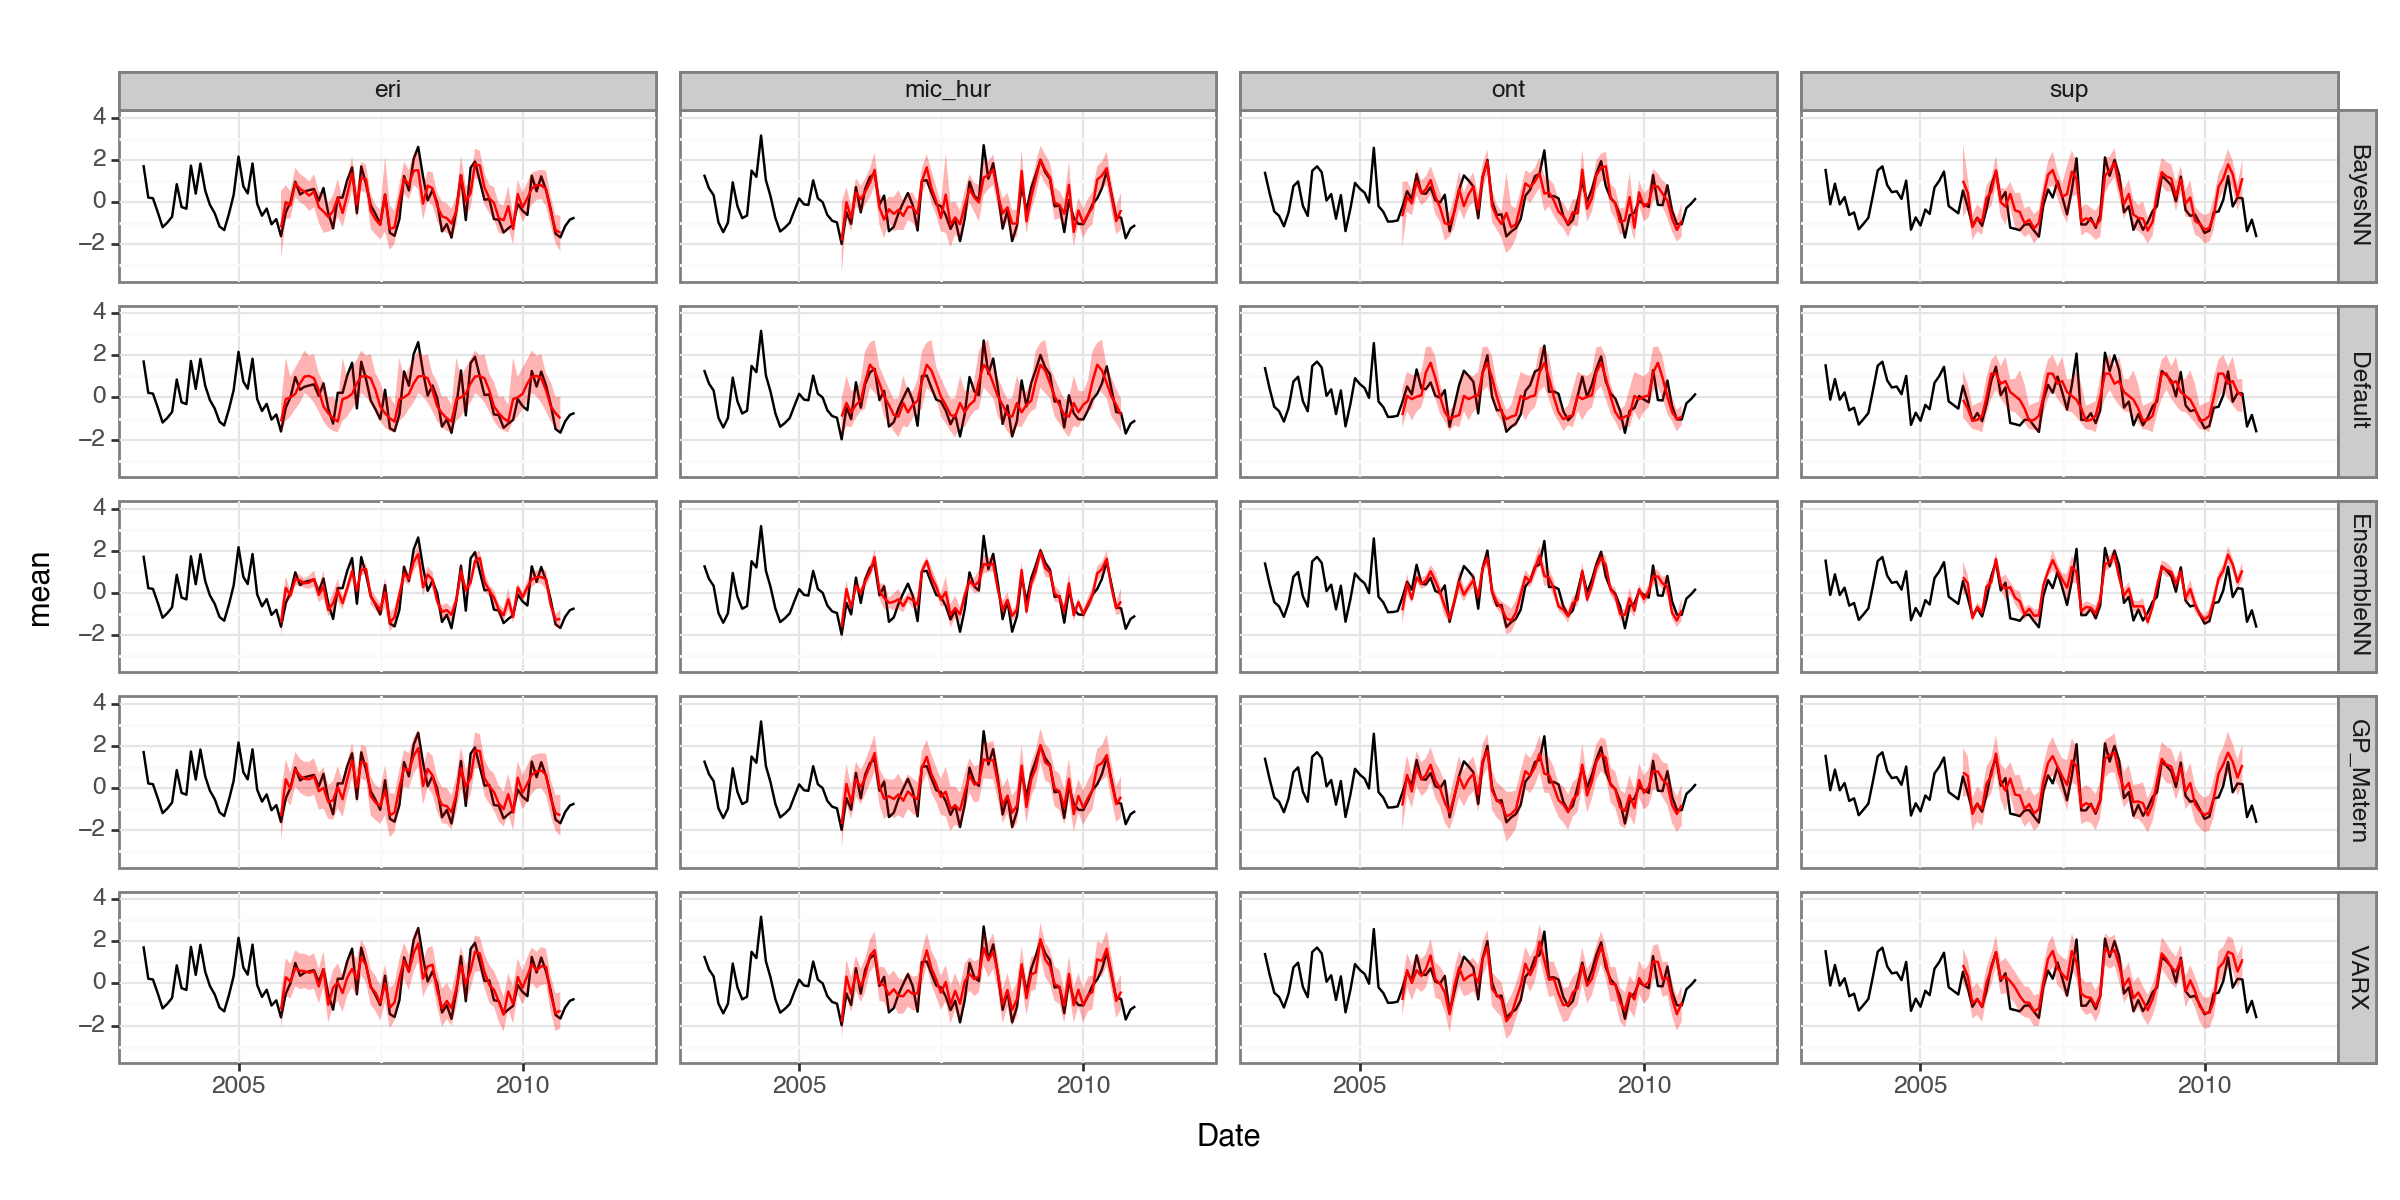

<Figure Size: (1200 x 600)>

In [7]:
import warnings

warnings.filterwarnings("ignore")

og = scaled_rnbs.to_dataframe(name="rnbs").reset_index()
result_subset = results_df[results_df["months_ahead"].isin([6])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean"), color="red")
        + facet_grid("model~lake")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)


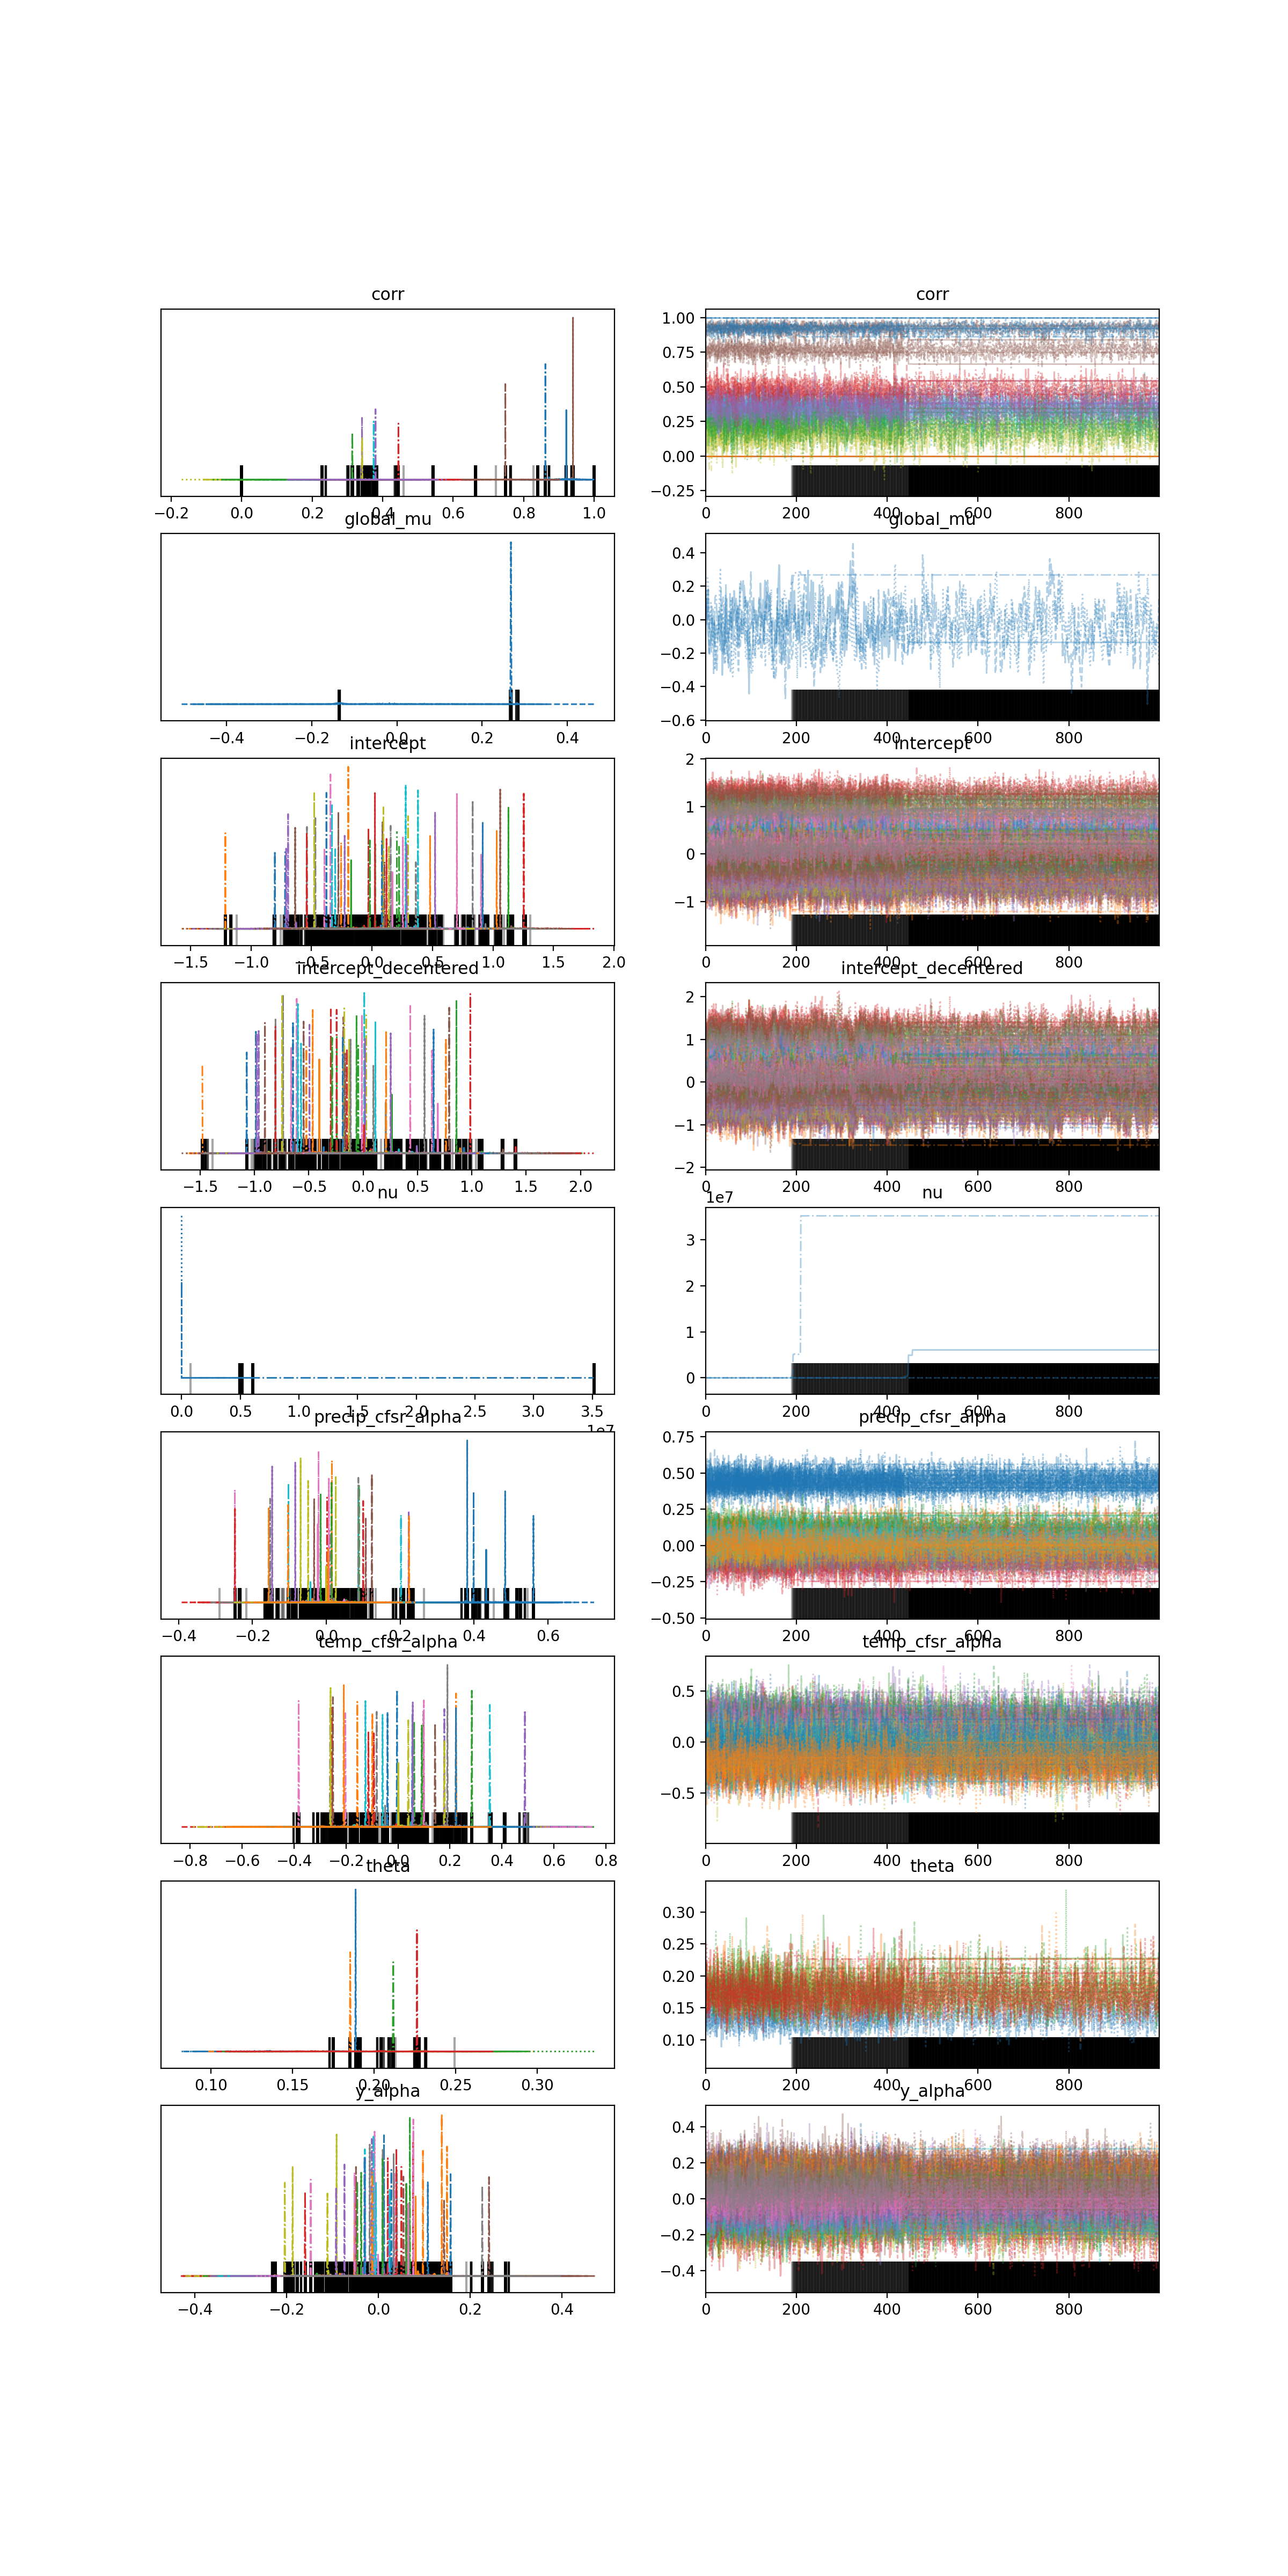

In [8]:
model = fitted_models["VARX"].steps[-1][1]
az.plot_trace(model.trace, figsize=(12, 24))

plt.show()


In [116]:
summarized = az.summary(model.trace, filter_vars="regex", var_names=["alpha"])

summarized[~((summarized["mean"] - 1.28 * summarized["sd"] <= 0) & (summarized["mean"] + 1.28 * summarized["sd"] >= 0))]

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
y_alpha[sup, ont, 1]     -0.115  0.073  -0.235    0.031      0.015    0.011   
y_alpha[mic_hur, sup, 0]  0.071  0.046  -0.002    0.171      0.010    0.007   
y_alpha[eri, eri, 0]     -0.179  0.080  -0.273   -0.023      0.025    0.020   
y_alpha[ont, sup, 0]     -0.106  0.059  -0.193    0.019      0.013    0.009   
y_alpha[ont, mic_hur, 1] -0.104  0.072  -0.240    0.042      0.006    0.004   

                          ess_bulk  ess_tail  r_hat  
y_alpha[sup, ont, 1]          23.0    2133.0   1.12  
y_alpha[mic_hur, sup, 0]      24.0    2268.0   1.11  
y_alpha[eri, eri, 0]          11.0    1177.0   1.27  
y_alpha[ont, sup, 0]          24.0    2143.0   1.11  
y_alpha[ont, mic_hur, 1]     184.0    2094.0   1.39

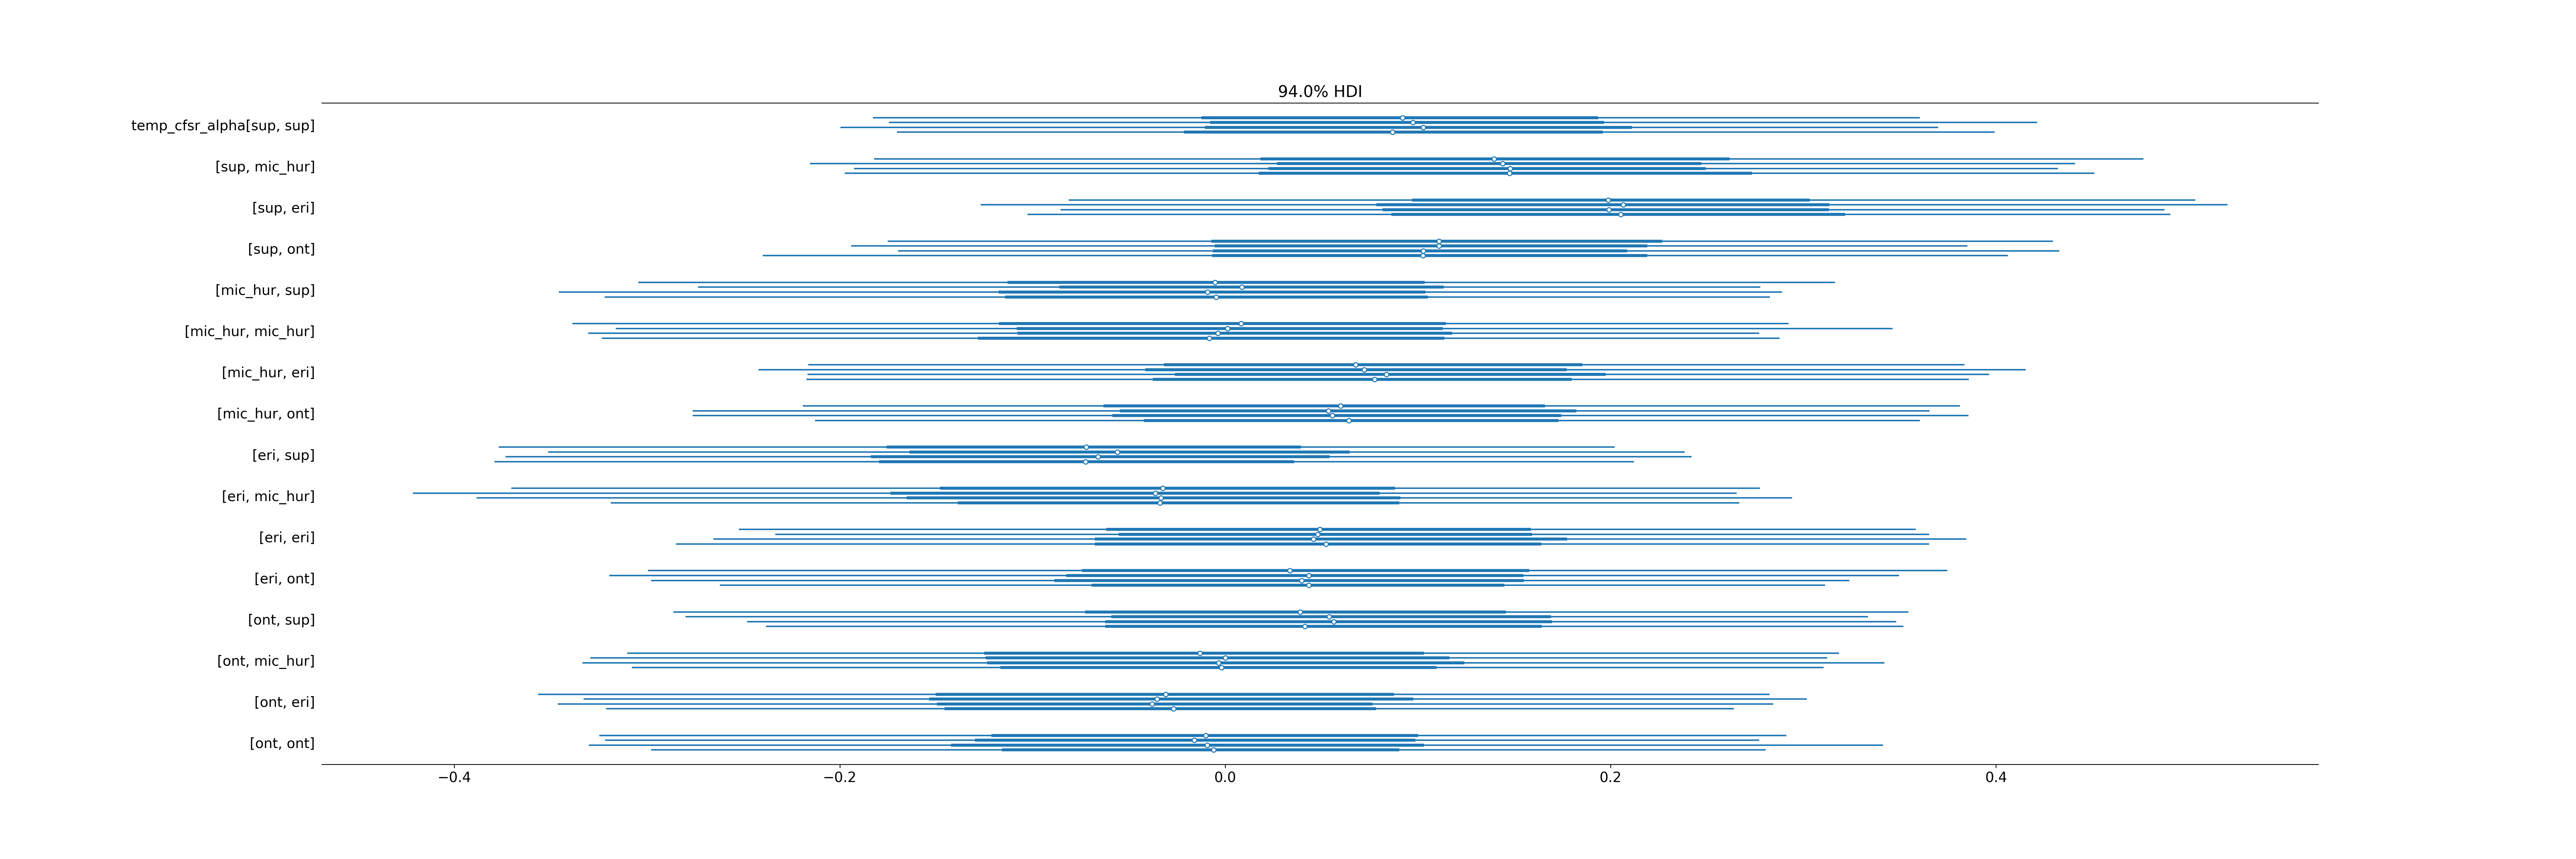

In [27]:
az.plot_forest(model.trace, var_names=["temp"], filter_vars="regex", figsize=(36, 12))

plt.show()